<h1><center>$\color{black}{\text{Climate Change Analysis for UC Santa Barbara}}$</center></h1>

**Part 1: Data Cleaning**

In [7]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import plotnine as p9
import requests_cache
requests_cache.install_cache('weather_cache')
from scipy.stats import spearmanr
import itertools
from itertools import repeat

from mizani.breaks import date_breaks
from mizani.formatters import date_format

In [8]:
url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"
Token = "eLCmbnPGUBzvYdVYFMZYpulbSoXjYkfX"
params = {'datasetid': 'GHCND', 'datatypeid': 'TMAX','limit': '1000', 'stationid': 'GHCND:USW00023190', \
          'units': 'standard', 'startdate': '2000-01-01','enddate': '2000-12-31'}
req = requests.get(url,params=params,headers={'token':Token})
js = req.json()
req.url

'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TMAX&enddate=2000-12-31&limit=1000&startdate=2000-01-01&stationid=GHCND%3AUSW00023190&units=standard'

In [9]:
year =  list(range(2000,2021))
df = pd.DataFrame()
for i in year:
    params['startdate'] = str(i)+'-01-01'
    params['enddate'] = str(i)+'-12-31'
    params['datatypeid'] = 'TMAX'
    tmax = requests.get(url,params=params,headers={'token':Token})
    tmax_temp = pd.DataFrame(tmax.json()['results'])
    tmax_temp['date'] = pd.to_datetime(tmax_temp['date'])
    tmax_temp = tmax_temp.rename(columns={"value": "max_temperature"})
    tmax_temp = tmax_temp.set_index('date').drop(['datatype'], axis=1)
    
    params['datatypeid'] = 'TMIN'
    tmin = requests.get(url,params=params,headers={'token':Token})
    tmin_temp = pd.DataFrame(tmin.json()['results'])
    tmin_temp['date'] = pd.to_datetime(tmin_temp['date'])
    tmin_temp = tmin_temp.set_index('date').drop(['station', 'attributes','datatype'], axis=1)
    tmin_temp = tmin_temp.rename(columns={"value": "min_temperature"})
    df_temp = tmax_temp.join(tmin_temp)
    
    params['datatypeid'] = 'PRCP'
    prcp = requests.get(url,params=params,headers={'token':Token})
    prcp_temp = pd.DataFrame(prcp.json()['results'])
    prcp_temp['date'] = pd.to_datetime(prcp_temp['date'])
    prcp_temp = prcp_temp.set_index('date').drop(['station', 'attributes','datatype'], axis=1)
    prcp_temp = prcp_temp.rename(columns={"value": "rain"})
    df_temp = df_temp.join(prcp_temp)
    
    df = pd.concat([df, df_temp])

In [10]:
df['diff'] = df.eval('max_temperature - min_temperature')
df

,station,attributes,max_temperature,min_temperature,rain,diff
date,,,,,,
2000-01-01,GHCND:USW00023190,",,W,2400",65.0,41.0,0.00,24.0
2000-01-02,GHCND:USW00023190,",,W,2400",69.0,44.0,0.00,25.0
2000-01-03,GHCND:USW00023190,",,W,2400",66.0,38.0,0.00,28.0
2000-01-04,GHCND:USW00023190,",,W,2400",67.0,36.0,0.00,31.0
2000-01-05,GHCND:USW00023190,",,W,2400",71.0,42.0,0.00,29.0
...,...,...,...,...,...,...
2020-12-27,GHCND:USW00023190,",,W,2400",63.0,44.0,0.65,19.0
2020-12-28,GHCND:USW00023190,",,W,2400",55.0,41.0,1.25,14.0
2020-12-29,GHCND:USW00023190,",,W,2400",62.0,36.0,0.00,26.0


**Part 2: Data Visualization(s)**

In [11]:
mon_df = df.copy()
mon_df.index = mon_df.index.to_period('M')
mon_df = mon_df.reset_index()

In [12]:
mon_df_mean = mon_df.groupby(['date']).mean().reset_index()
year_df = df.copy()
year_df.index = year_df.index.year
year_df = year_df.reset_index()
year_df['date'] = year_df['date'].astype(str)
year_df_max = year_df.groupby(['date']).max().reset_index()

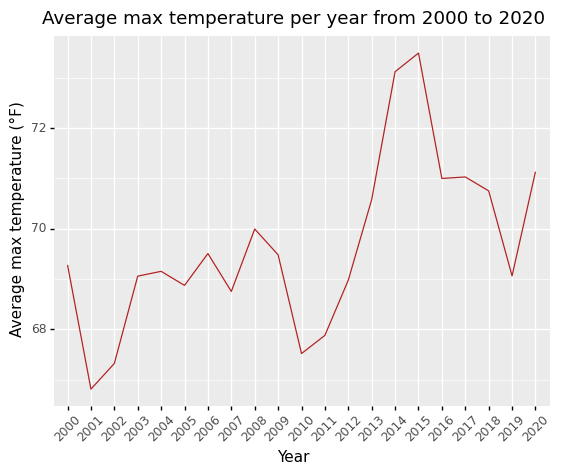

<ggplot: (8763889685239)>

In [13]:
year_df_mean = year_df.groupby(['date']).mean().reset_index()
p9.ggplot(year_df_mean) + p9.aes(x='date',y='max_temperature',group = 1) + \
p9.geom_line(color='firebrick') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.labs(x = "Year", y = "Average max temperature (°F)", \
     title = "Average max temperature per year from 2000 to 2020")

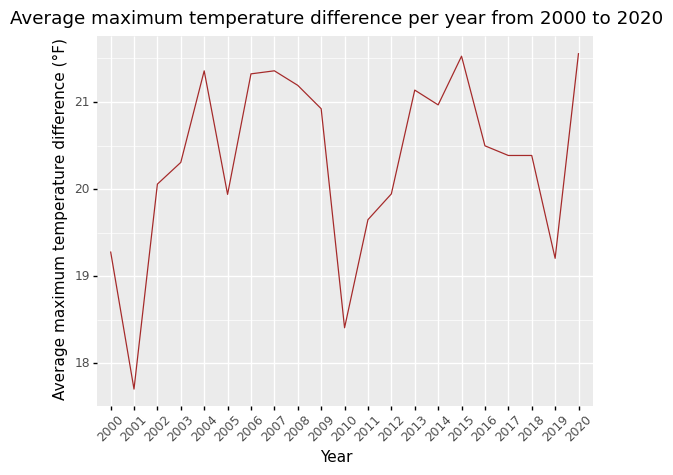

<ggplot: (8763890037495)>

In [14]:
p9.ggplot(year_df_mean) + p9.aes(x='date',y='diff',group = 1) + \
p9.geom_line(color='brown') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.labs(x = "Year", y = "Average maximum temperature difference (°F)", \
     title = "Average maximum temperature difference per year from 2000 to 2020")

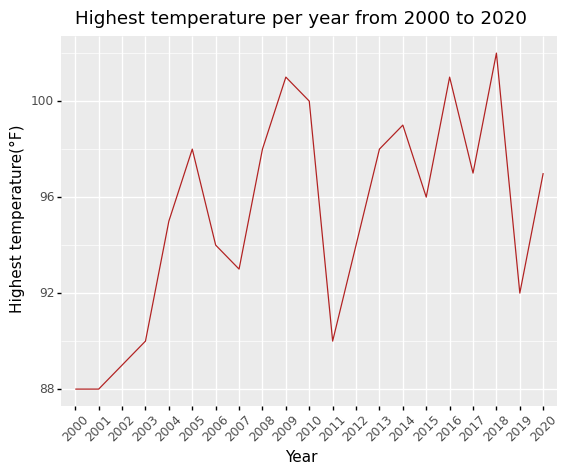

<ggplot: (8763890163697)>

In [15]:
p9.ggplot(year_df_max) + p9.aes(x='date',y='max_temperature',group = 1) + \
p9.geom_line(color='firebrick') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.labs(x = "Year", y = "Highest temperature(°F)", \
     title = "Highest temperature per year from 2000 to 2020")

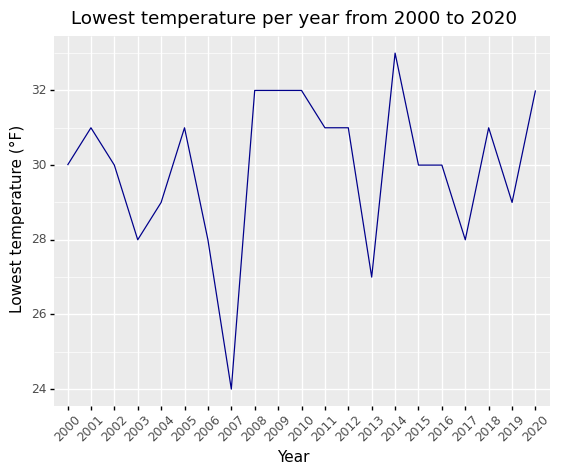

<ggplot: (8763890810899)>

In [16]:
year_df_min = year_df.groupby(['date']).min().reset_index()
p9.ggplot(year_df_min) + p9.aes(x='date',y='min_temperature',group = 1) + \
p9.geom_line(color='darkblue') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.labs(x = "Year", y = "Lowest temperature (°F)", \
     title = "Lowest temperature per year from 2000 to 2020")

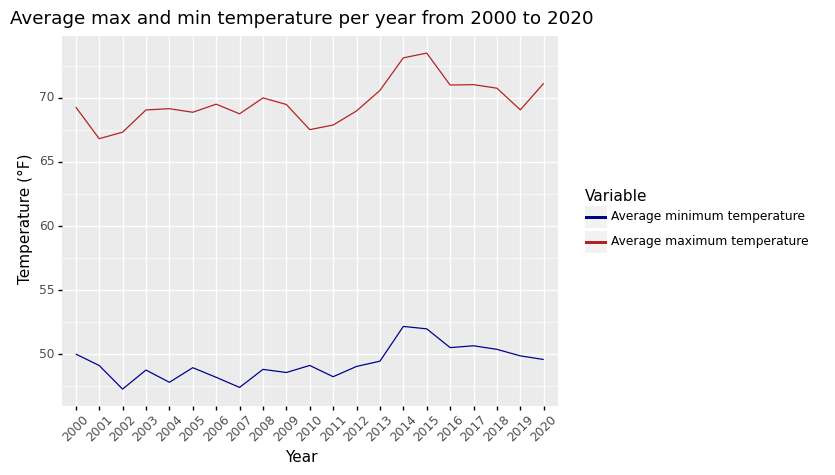

<ggplot: (8763890046097)>

In [17]:
p9.ggplot(year_df_mean, p9.aes(x='date',y='min_temperature',group = 1)) + \
p9.geom_line(p9.aes(y='min_temperature', color='"darkblue"')) +\
p9.geom_line(p9.aes(y='max_temperature', color='"firebrick"')) +\
p9.scale_color_identity(guide='legend', name = "Variable", breaks=['darkblue', 'firebrick'], 
                        labels=['Average minimum temperature', 'Average maximum temperature']) +\
p9.themes.theme(axis_text_x=p9.element_text(angle=45)) +\
p9.labs(x = "Year", y = "Temperature (°F)", \
     title = "Average max and min temperature per year from 2000 to 2020")

In [18]:
season_df = df.copy()
season_df['year'] = season_df.index.year
season_df['month']= season_df.index.month
season_df = season_df.reset_index()
season_df['month'] = season_df['month'].astype(int)
season_df['season'] = season_df['month']%12 // 3 + 1

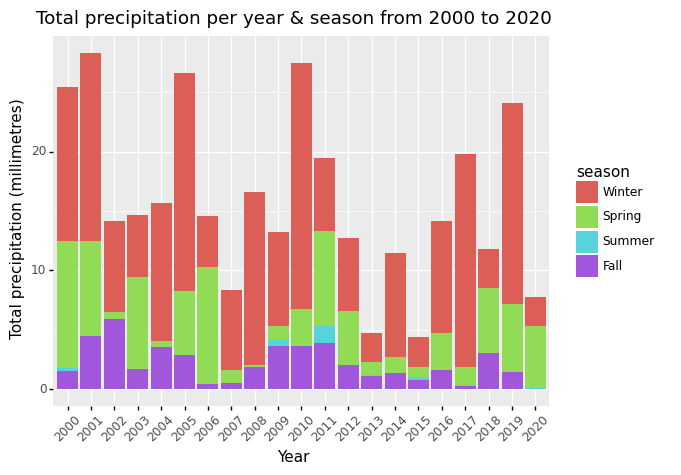

<ggplot: (8763890001402)>

In [19]:
season_df_sum = season_df.groupby(['year','season']).sum().reset_index()
season_df_sum['year'] = season_df_sum['year'].astype(str)
season_df_sum['season'] = season_df_sum['season'].astype(str)
p9.ggplot(season_df_sum) + p9.aes(x='year',y='rain',fill='season') + \
p9.geom_col() + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.scale_fill_discrete(labels = ["Winter", "Spring","Summer","Fall"]) + \
p9.labs(x = "Year", y = "Total precipitation (millimetres)", \
     title = "Total precipitation per year & season from 2000 to 2020")

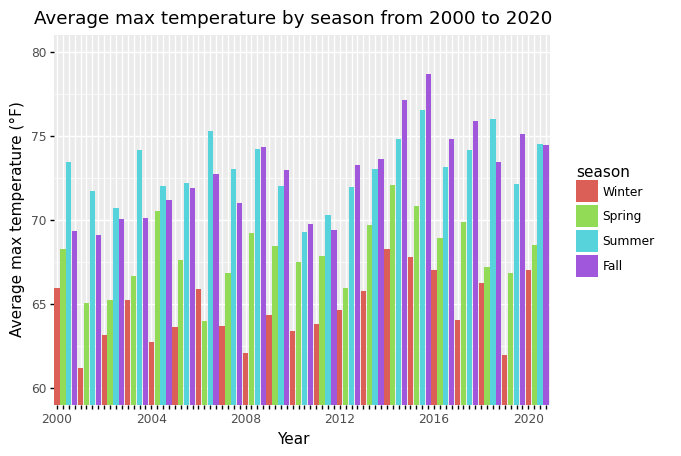

<ggplot: (8763889833382)>

In [20]:
x_label = list()
x = 2000
for i in range(84):
    if i%16 == 0:
        x_label.append(str(x)) 
        x += 4
    else:
        x_label.append('')
        
season_df_mean = season_df.groupby(['year','season']).mean().reset_index()
season_df_mean['year'] = season_df_mean['year'].astype(str)
season_df_mean['season'] = season_df_mean['season'].astype(str)


season_df_mean['year_season'] = season_df_mean['year'].astype(str) + "," + season_df_mean['season'].astype(str)
p9.ggplot(season_df_mean) + p9.aes(x='year_season',y='max_temperature',fill='season') + p9.geom_col() + \
p9.scale_x_discrete(labels = x_label) + p9.coord_cartesian(ylim = [60, 80]) + \
p9.scale_fill_discrete(labels = ["Winter", "Spring","Summer","Fall"]) + \
p9.labs(x = "Year", y = "Average max temperature (°F)", \
     title = "Average max temperature by season from 2000 to 2020")

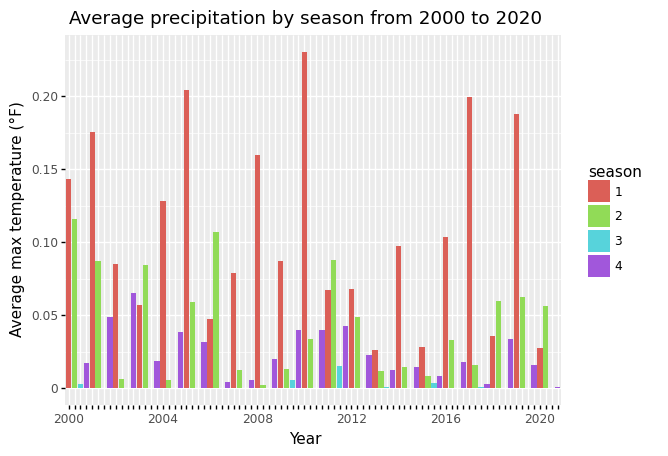

<ggplot: (8763891494370)>

In [21]:
p9.ggplot(season_df_mean) + p9.aes(x='year_season',y='rain',fill='season') + p9.geom_col() + \
p9.scale_x_discrete(labels = x_label) + \
p9.labs(x = "Year", y = "Average max temperature (°F)", \
     title = "Average precipitation by season from 2000 to 2020")

**Part 3: Statistical Analysis**

In [22]:
year_2000 = year_df.loc[year_df['date'] == '2000','max_temperature']
year_2020 = year_df.loc[year_df['date'] == '2020','max_temperature']
print(year_2000.mean())
print(year_2020.mean())
#Two sample t-test
print(stats.ttest_ind(a=year_2020,b=year_2000,alternative='greater'))
# 95% C.I. for 2000 and 2020
print(stats.t.interval(alpha=0.95, df=len(year_2000)-1, loc=np.mean(year_2000), scale=stats.sem(year_2000)))
print(stats.t.interval(alpha=0.95, df=len(year_2020)-1, loc=np.mean(year_2020), scale=stats.sem(year_2020)))

69.28142076502732
71.13424657534246
Ttest_indResult(statistic=3.790339098526587, pvalue=8.143746919958672e-05)
(68.69169835093801, 69.87114317911663)
(70.37470099404584, 71.89379215663908)


In [23]:
grps = [d['max_temperature'].tolist() for _, d in year_df.groupby('date')]
print(stats.f_oneway(*grps))
print(stats.kruskal(*grps))

F_onewayResult(statistic=22.025764608533727, pvalue=2.1338040919725396e-78)
KruskalResult(statistic=397.47569190627075, pvalue=6.823882839785595e-72)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator


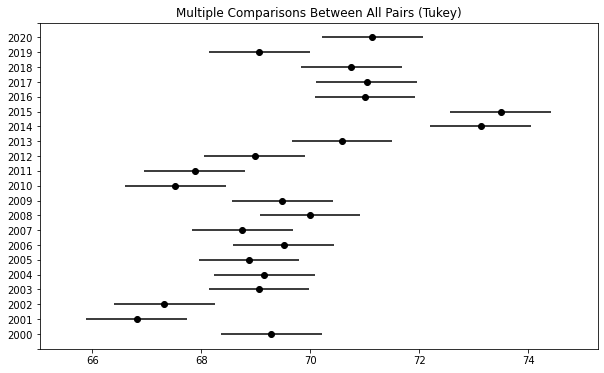

In [24]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=year_df['max_temperature'],groups=year_df['date'],alpha=0.05)
tukey_plot = tukey.plot_simultaneous()

In [25]:
grps = [d['rain'].tolist() for _, d in year_df.groupby('date')]
stats.f_oneway(*grps)

F_onewayResult(statistic=2.35811157814616, pvalue=0.000573128342337391)

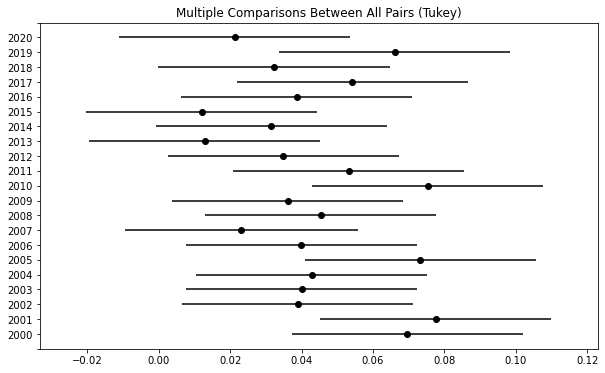

In [26]:
tukey = pairwise_tukeyhsd(endog=year_df['rain'],groups=year_df['date'],alpha=0.05)
tukey_plot = tukey.plot_simultaneous()

<h1><center>$\color{black}{\text{End}}$</center></h1>